# Using linearBERT Architecture for Sequence Classification

Summary:


In [1]:
# Mount into drive

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
# This is the location of the root directory (on github it would be cs7643-project)
# Yours might look different - Megan
root = '/content/drive/MyDrive/CS7643/cs7643-project'

In [ ]:
# Detect PY file updates and reload
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [4]:
#%cd drive/MyDrive/Colab\ Notebooks/dl_project
import os
os.chdir(root)
%pwd

'/content/drive/MyDrive/CS7643/cs7643-project'

In [5]:
%ls

data/  notebooks/  proposal/  README.md  source/  Tutorials


### Installations

In [ ]:
!pip install transformers
!pip install datasets
!pip install adjustText
!pip install wandb -qqq

In [7]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
!pip install -r 'notebooks/requirement.txt'

In [9]:
import logging
import time
from platform import python_version

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import torch
import torch.nn as nn
import torch.nn.functional as F
import transformers
from torch.autograd import Variable
from transformers import BertTokenizer, BertModel
from torch.optim import Adam, Adadelta
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from platform import python_version

In [10]:
print("python version==%s" % python_version())
print("pandas==%s" % pd.__version__)
print("numpy==%s" % np.__version__)
print("torch==%s" % torch.__version__)
print("sklearn==%s" % sklearn.__version__)
print("transformers==%s" % transformers.__version__)
print("matplotlib==%s" % matplotlib.__version__)

python version==3.7.13
pandas==1.3.5
numpy==1.21.6
torch==1.10.0+cu111
sklearn==1.0.2
transformers==4.18.0
matplotlib==3.2.2


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### get embeddings using BERT

Each file note becomes a 2D tensor:
* Each row is a token or subtoken in the sequence
* Each column is a value in the embedding (vector) for that token

In [12]:
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### run training data through BERT and Linear Layer



In [13]:
import random
import time

def set_seed(seed_value=42):
    """Set seed for reproducibility."""

    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)


##Example Experiment

In [14]:
import pprint
myrun=wandb.init(project="LinearBert", entity="cs7643-teamscam")

wandb: Currently logged in as: cs7643-teamscam (use `wandb login --relogin` to force relogin)


Create sweep with ID: 6wjdcgcn
Sweep URL: https://wandb.ai/cs7643-teamscam/LinearBert/sweeps/6wjdcgcn


wandb: Agent Starting Run: tze7jj2o with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.2
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   1    |   0.469127   |   82.06   |  0.364166  |   94.53   |   3.57   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   2    |   0.374111   |   93.58   |  0.390234  |   95.31   |   4.90   


Training complete! Best accuracy: 95.31%.
epochs: [0. 1.] 
train_loss: [0.46912732 0.37411069] 
val_loss: [0.36416589 0.39023364]


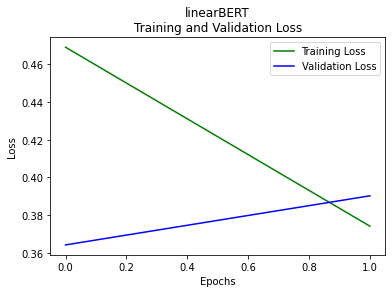

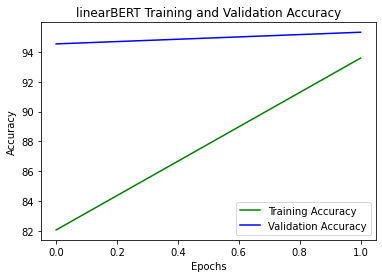

  0%|          | 0/2 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.4218292385339737,91.31944444444444)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁█
val_loss,▁█
avg_train_loss,0.37411
epoch,1
train_acc,93.57955
val_accuracy,95.3125
val_loss,0.39023


wandb: Agent Starting Run: 4acnx6xh with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.5
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   1    |   0.460932   |   82.56   |  0.384396  |   93.01   |   3.40   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   2    |   0.374955   |   94.72   |  0.357346  |   95.70   |   3.47   


Training complete! Best accuracy: 95.70%.
epochs: [0. 1.] 
train_loss: [0.46093202 0.37495489] 
val_loss: [0.38439558 0.35734621]


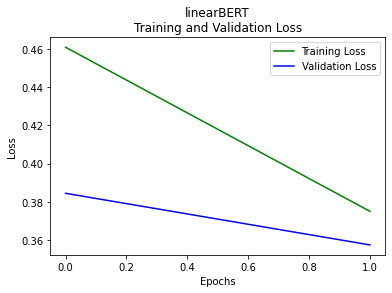

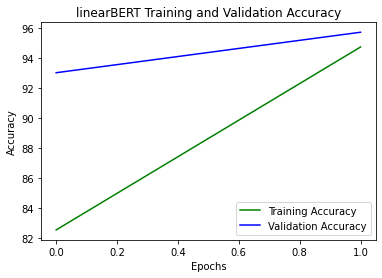

  0%|          | 0/1 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.3866649270057678,93.0)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁█
val_loss,█▁
avg_train_loss,0.37495
epoch,1
train_acc,94.72222
val_accuracy,95.70312
val_loss,0.35735


wandb: Agent Starting Run: 26ce1a2p with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   1    |   0.511252   |   79.08   |  0.374517  |   94.79   |   3.40   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   2    |   0.398305   |   91.71   |  0.401816  |   90.84   |   2.23   


Training complete! Best accuracy: 94.79%.
epochs: [0. 1.] 
train_loss: [0.51125158 0.39830501] 
val_loss: [0.37451714 0.40181641]


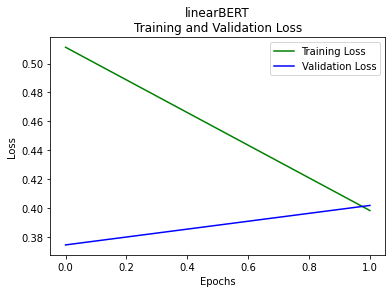

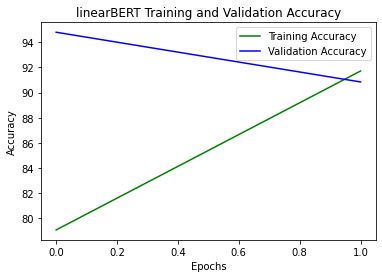

  0%|          | 0/1 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.4067545235157013,92.0)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,█▁
val_loss,▁█
avg_train_loss,0.39831
epoch,1
train_acc,91.71007
val_accuracy,90.84201
val_loss,0.40182


wandb: Agent Starting Run: l8itv1xg with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0.2
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.1
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

   1    |   0.774783   |   53.15   |  0.844512  |   46.88   |   3.61   


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

   2    |   0.774503   |   53.88   |  0.844512  |   46.88   |   2.61   


Training complete! Best accuracy: 46.88%.
epochs: [0. 1.] 
train_loss: [0.77478337 0.77450349] 
val_loss: [0.84451164 0.84451164]


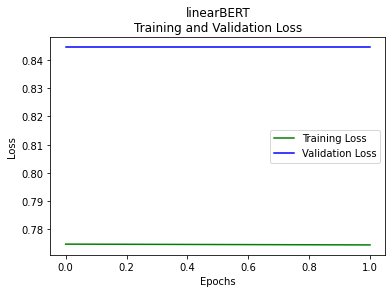

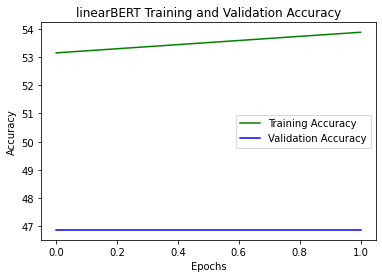

  0%|          | 0/4 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7507616579532623,56.25)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁▁
val_loss,▁▁
avg_train_loss,0.7745
epoch,1
train_acc,53.87581
val_accuracy,46.875
val_loss,0.84451


wandb: Agent Starting Run: flze6fyl with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.001
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   1    |   0.467399   |   84.63   |  0.371607  |   94.14   |   3.62   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   2    |   0.351428   |   96.57   |  0.364209  |   95.31   |   3.63   


Training complete! Best accuracy: 95.31%.
epochs: [0. 1.] 
train_loss: [0.46739882 0.35142806] 
val_loss: [0.37160659 0.36420856]


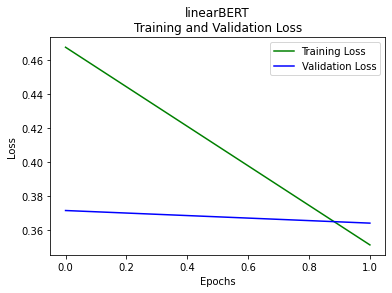

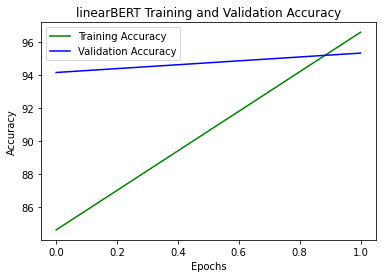

  0%|          | 0/2 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.36786673963069916,94.09722222222223)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁█
val_loss,█▁
avg_train_loss,0.35143
epoch,1
train_acc,96.57197
val_accuracy,95.3125
val_loss,0.36421


wandb: Agent Starting Run: dkttfrbt with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.001
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

   1    |   0.428091   |   87.59   |  0.369249  |   95.67   |   3.76   


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

   2    |   0.340685   |   97.59   |  0.367412  |   95.67   |   2.58   


Training complete! Best accuracy: 95.67%.
epochs: [0. 1.] 
train_loss: [0.4280906  0.34068486] 
val_loss: [0.36924936 0.36741218]


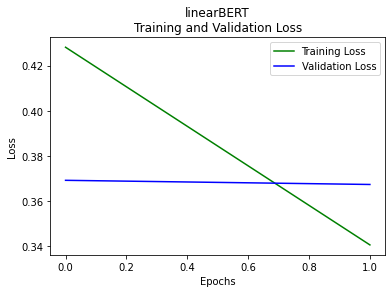

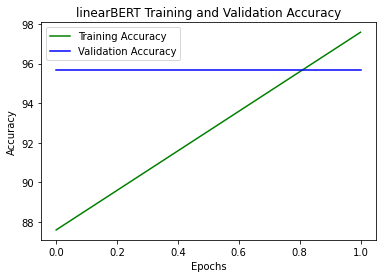

  0%|          | 0/7 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.3763569508280073,92.85714285714286)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁▁
val_loss,█▁
avg_train_loss,0.34068
epoch,1
train_acc,97.58523
val_accuracy,95.67308
val_loss,0.36741


wandb: Agent Starting Run: 2d54twrr with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

   1    |   0.774807   |   53.74   |  0.827685  |   48.56   |   3.83   


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

   2    |   0.766960   |   54.55   |  0.827685  |   48.56   |   2.71   


Training complete! Best accuracy: 48.56%.
epochs: [0. 1.] 
train_loss: [0.77480659 0.76695956] 
val_loss: [0.82768496 0.82768496]


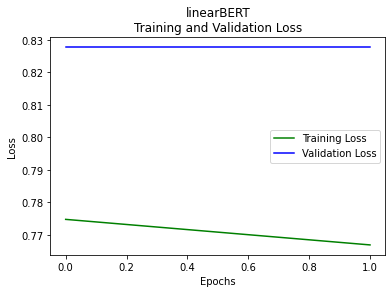

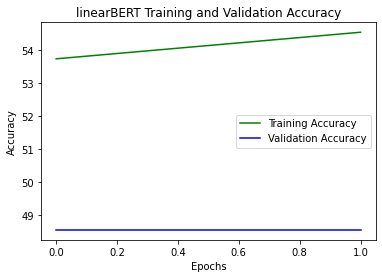

  0%|          | 0/7 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7418333121708461,57.142857142857146)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁▁
val_loss,▁▁
avg_train_loss,0.76696
epoch,1
train_acc,54.54545
val_accuracy,48.55769
val_loss,0.82768


wandb: Agent Starting Run: hfhbnare with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   1    |   0.778945   |   51.49   |  0.811091  |   50.22   |   3.56   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   2    |   0.779581   |   53.37   |  0.811091  |   50.22   |   2.25   


Training complete! Best accuracy: 50.22%.
epochs: [0. 1.] 
train_loss: [0.7789451  0.77958105] 
val_loss: [0.81109133 0.81109133]


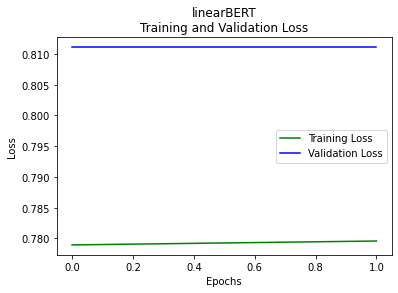

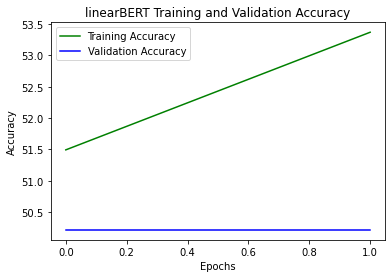

  0%|          | 0/1 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7332618832588196,57.99999999999999)


avg_train_loss,▁█
epoch,▁█
train_acc,▁█
val_accuracy,▁▁
val_loss,▁▁
avg_train_loss,0.77958
epoch,1
train_acc,53.36806
val_accuracy,50.21701
val_loss,0.81109


wandb: Agent Starting Run: fntqzm94 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

   1    |   0.773422   |   53.47   |  0.844512  |   46.88   |   4.98   


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

   2    |   0.774503   |   53.88   |  0.844512  |   46.88   |   2.38   


Training complete! Best accuracy: 46.88%.
epochs: [0. 1.] 
train_loss: [0.77342196 0.77450297] 
val_loss: [0.84451164 0.84451164]


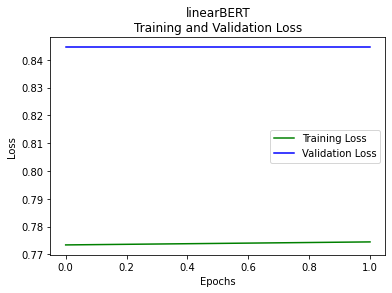

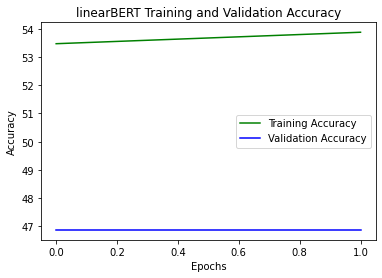

  0%|          | 0/4 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7507616579532623,56.25)


avg_train_loss,▁█
epoch,▁█
train_acc,▁█
val_accuracy,▁▁
val_loss,▁▁
avg_train_loss,0.7745
epoch,1
train_acc,53.87581
val_accuracy,46.875
val_loss,0.84451


wandb: Agent Starting Run: ey7iwyt9 with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.001
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

   1    |   0.408269   |   91.57   |  0.362881  |   95.67   |   4.06   


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

   2    |   0.338195   |   97.73   |  0.356764  |   95.67   |   2.95   


Training complete! Best accuracy: 95.67%.
epochs: [0. 1.] 
train_loss: [0.40826858 0.33819535] 
val_loss: [0.36288131 0.35676436]


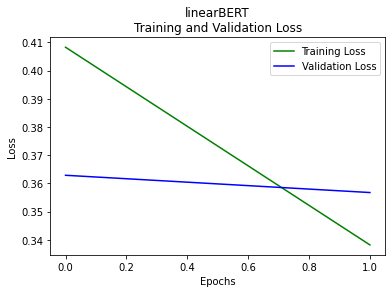

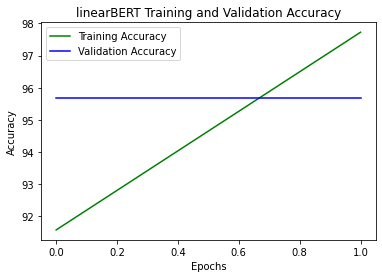

  0%|          | 0/7 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.3633182304246085,95.53571428571429)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁▁
val_loss,█▁
avg_train_loss,0.3382
epoch,1
train_acc,97.72727
val_accuracy,95.67308
val_loss,0.35676


wandb: Agent Starting Run: su1jnmjs with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.001
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

   1    |   0.438428   |   86.06   |  0.376872  |   94.20   |   4.67   


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

   2    |   0.342628   |   97.16   |  0.361291  |   95.09   |   4.44   


Training complete! Best accuracy: 95.09%.
epochs: [0. 1.] 
train_loss: [0.43842775 0.34262764] 
val_loss: [0.37687184 0.36129086]


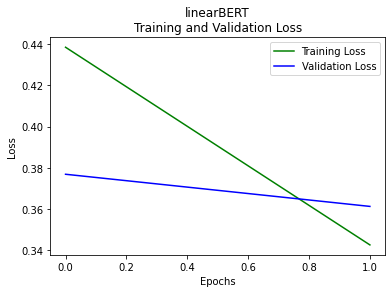

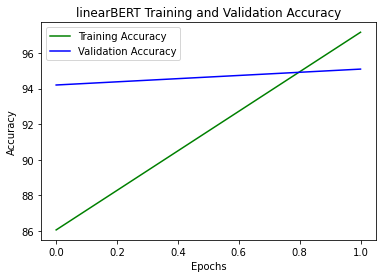

  0%|          | 0/4 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.3932534232735634,90.625)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁█
val_loss,█▁
avg_train_loss,0.34263
epoch,1
train_acc,97.15909
val_accuracy,95.08929
val_loss,0.36129


wandb: Agent Starting Run: uthctdjw with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0.2
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   1    |   0.548781   |   73.85   |  0.382794  |   92.45   |   3.49   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   2    |   0.397948   |   91.14   |  0.420533  |   89.45   |   2.23   


Training complete! Best accuracy: 92.45%.
epochs: [0. 1.] 
train_loss: [0.5487815  0.39794839] 
val_loss: [0.38279448 0.42053308]


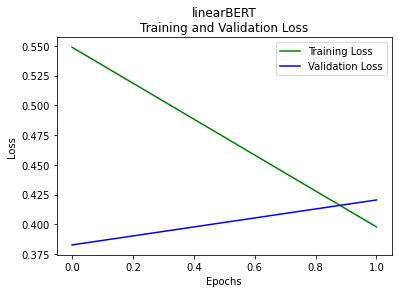

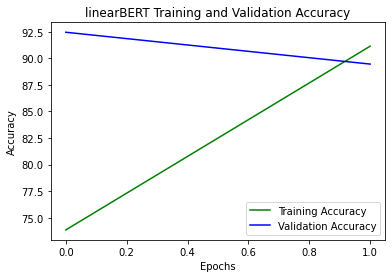

  0%|          | 0/1 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.4358219504356384,87.0)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,█▁
val_loss,▁█
avg_train_loss,0.39795
epoch,1
train_acc,91.13715
val_accuracy,89.45312
val_loss,0.42053


wandb: Agent Starting Run: 57dcr8d2 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.001
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   1    |   0.665609   |   61.56   |  0.391470  |   92.97   |   3.54   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   2    |   0.390132   |   91.86   |  0.392367  |   93.36   |   3.66   


Training complete! Best accuracy: 93.36%.
epochs: [0. 1.] 
train_loss: [0.66560867 0.39013206] 
val_loss: [0.3914696  0.39236674]


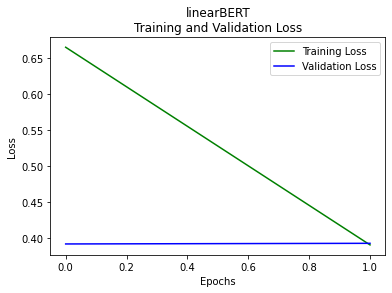

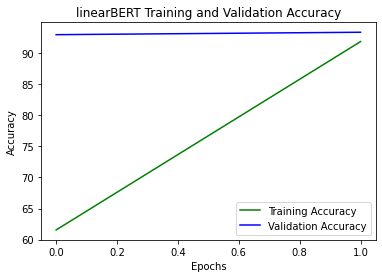

  0%|          | 0/2 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.41274294257164,93.31597222222223)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁█
val_loss,▁█
avg_train_loss,0.39013
epoch,1
train_acc,91.85606
val_accuracy,93.35938
val_loss,0.39237


wandb: Agent Starting Run: 0kx8to4j with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0.5
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

   1    |   0.838835   |   47.16   |  0.779612  |   53.37   |   3.80   


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

   2    |   0.833894   |   47.96   |  0.779608  |   53.37   |   2.75   


Training complete! Best accuracy: 53.37%.
epochs: [0. 1.] 
train_loss: [0.83883475 0.83389355] 
val_loss: [0.77961201 0.77960804]


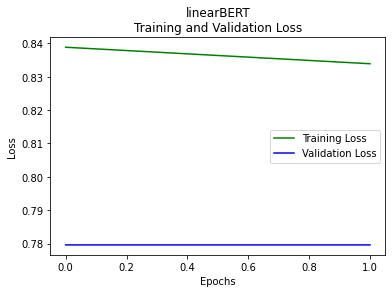

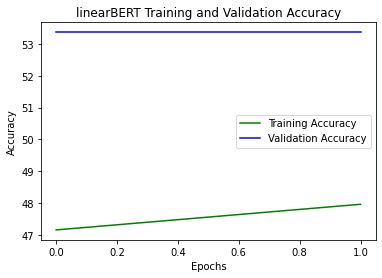

  0%|          | 0/7 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.8668332781110492,44.642857142857146)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁▁
val_loss,█▁
avg_train_loss,0.83389
epoch,1
train_acc,47.96402
val_accuracy,53.36538
val_loss,0.77961


wandb: Agent Starting Run: tkossbcp with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   1    |   0.776428   |   52.85   |  0.871855  |   44.14   |   3.56   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   2    |   0.774815   |   53.84   |  0.871855  |   44.14   |   2.49   


Training complete! Best accuracy: 44.14%.
epochs: [0. 1.] 
train_loss: [0.77642827 0.77481464] 
val_loss: [0.87185541 0.87185541]


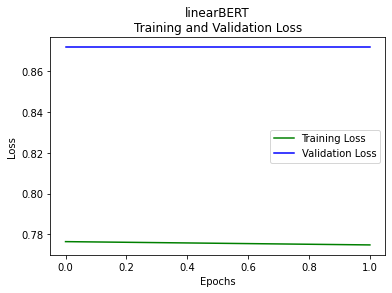

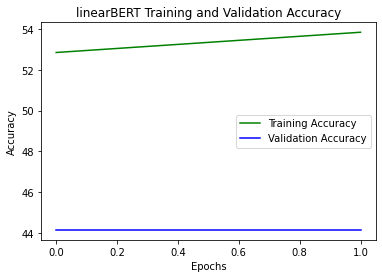

  0%|          | 0/2 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7264560461044312,58.68055555555556)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁▁
val_loss,▁▁
avg_train_loss,0.77481
epoch,1
train_acc,53.8447
val_accuracy,44.14062
val_loss,0.87186


wandb: Agent Starting Run: jp1f44xr with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

   1    |   0.722804   |   54.02   |  0.546791  |   48.56   |   3.86   


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

   2    |   0.581722   |   55.30   |  0.568643  |   48.56   |   2.59   


Training complete! Best accuracy: 48.56%.
epochs: [0. 1.] 
train_loss: [0.72280428 0.5817222 ] 
val_loss: [0.54679136 0.56864324]


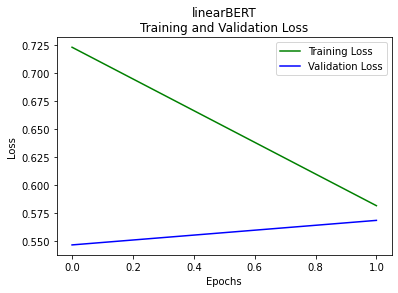

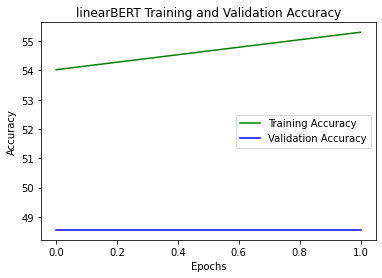

  0%|          | 0/7 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.5814030511038644,57.142857142857146)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁▁
val_loss,▁█
avg_train_loss,0.58172
epoch,1
train_acc,55.30303
val_accuracy,48.55769
val_loss,0.56864


wandb: Agent Starting Run: 14c29n6g with config:
wandb: 	batch_size: 16
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

   1    |   0.507811   |   80.82   |  0.408051  |   91.83   |   3.78   


  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

   2    |   0.434437   |   88.40   |  0.415836  |   91.35   |   2.75   


Training complete! Best accuracy: 91.83%.
epochs: [0. 1.] 
train_loss: [0.50781091 0.4344371 ] 
val_loss: [0.40805075 0.41583587]


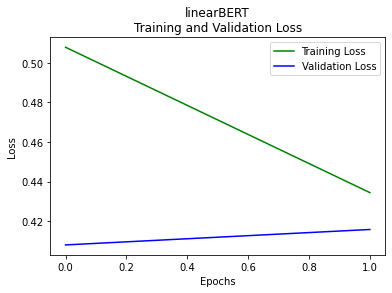

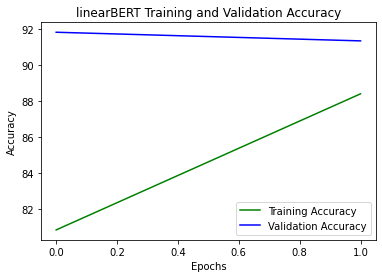

  0%|          | 0/7 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.41787696736199514,91.07142857142857)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,█▁
val_loss,▁█
avg_train_loss,0.43444
epoch,1
train_acc,88.39962
val_accuracy,91.34615
val_loss,0.41584


wandb: Agent Starting Run: w85x2sv0 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.5
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   1    |   0.525210   |   76.79   |  0.419930  |   94.14   |   4.59   


  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

   2    |   0.393317   |   92.73   |  0.361450  |   93.75   |   2.39   


Training complete! Best accuracy: 94.14%.
epochs: [0. 1.] 
train_loss: [0.52521024 0.39331652] 
val_loss: [0.41992964 0.36144958]


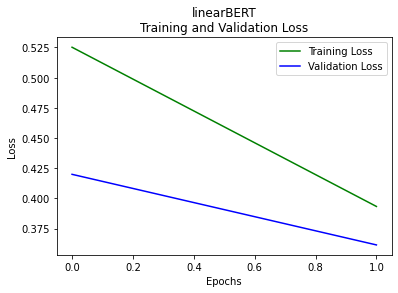

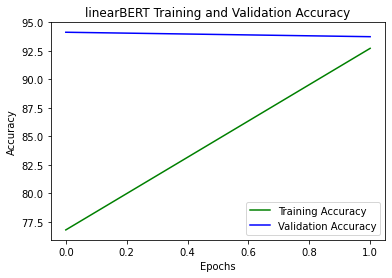

  0%|          | 0/2 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.37739913165569305,93.31597222222223)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,█▁
val_loss,█▁
avg_train_loss,0.39332
epoch,1
train_acc,92.72727
val_accuracy,93.75
val_loss,0.36145


wandb: Agent Starting Run: wu9pqy42 with config:
wandb: 	batch_size: 32
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.1
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

   1    |   0.845750   |   46.06   |  0.782012  |   53.12   |   3.61   


  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

   2    |   0.802394   |   52.41   |  0.640824  |   75.00   |   5.12   


Training complete! Best accuracy: 75.00%.
epochs: [0. 1.] 
train_loss: [0.84574955 0.80239441] 
val_loss: [0.7820116 0.6408238]


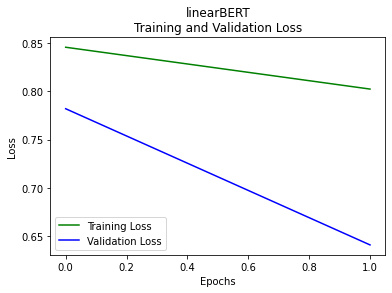

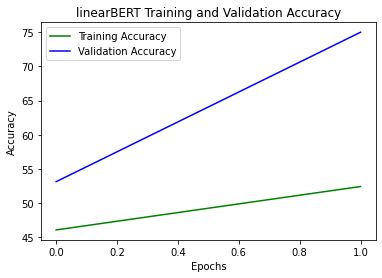

  0%|          | 0/4 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.7064163535833359,70.3125)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,▁█
val_loss,█▁
avg_train_loss,0.80239
epoch,1
train_acc,52.41477
val_accuracy,75.0
val_loss,0.64082


wandb: Agent Starting Run: bgxr3k5a with config:
wandb: 	batch_size: 128
wandb: 	dropout: 0
wandb: 	emb_size: 768
wandb: 	epochs: 2
wandb: 	learning_rate: 0.01
wandb: 	max_length: 64
wandb: 	num_classes: 2
wandb: 	opt: adam
wandb: 	rho: 0.95
wandb: WARNING Ignored wandb.init() arg project when running a sweep.
wandb: WARNING Ignored wandb.init() arg entity when running a sweep.


Using custom data configuration data-640c1151ef84ed15
Reusing dataset csv (/root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-d64a8e932993f4f0.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-b4e9470caa68630e.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/csv/data-640c1151ef84ed15/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519/cache-be3f61f789ef3e9a.arrow


Start training...

 Epoch  |  Train Loss  |  Train Acc  |  Val Loss  |  Val Acc  |  Elapsed 
------------------------------------------------------------


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   1    |   0.499518   |   80.04   |  0.383285  |   94.40   |   3.60   


  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

   2    |   0.372716   |   94.63   |  0.383983  |   91.67   |   2.76   


Training complete! Best accuracy: 94.40%.
epochs: [0. 1.] 
train_loss: [0.49951755 0.37271597] 
val_loss: [0.3832849  0.38398343]


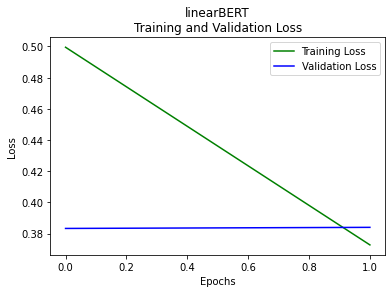

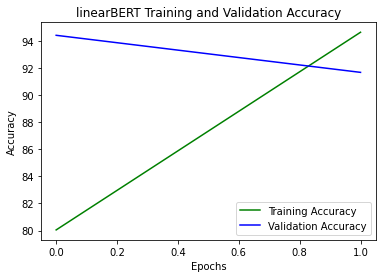

  0%|          | 0/1 [00:00<?, ?it/s]

Final Loss and Accuracy on Test: (0.41333523392677307,91.0)


avg_train_loss,█▁
epoch,▁█
train_acc,▁█
val_accuracy,█▁
val_loss,▁█
avg_train_loss,0.37272
epoch,1
train_acc,94.62674
val_accuracy,91.66667
val_loss,0.38398


In [42]:
from source import train
from source.models.linearBERT import initialize_model, linearBERT
from source.dataloader.get_data import bert_data
from source.plot import experiment_plot
from source import train, evaluate
import wandb
import pprint

sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'learning_rate': {
            'values': [1e-1, 1e-2, 1e-3]
        },
        'batch_size': {
            'values': [16, 32, 64, 128]
        },
        'epochs':{
            'values':[2]#10]
        },
        'max_length':{
            'values':[64]#, 128, 512]
        },
        'dropout':{
            'values':[0.0,0.2,0.5]
        },
        'opt':{
            'values':['adam']#,'ada']
        },
        'rho':{
            'values':[0.95]
        },
        'emb_size':{ # should not change
            'value':768
        },
        'num_classes':{ # should not change (with standard dataset)
            'value':2
        }
    }
}
'''sweep_defaults = {
    'learning_rate': 5e-5,
    'batch_size': 68,
    'epochs':2
}'''

def run():
  with wandb.init(project="LinearBert", entity="cs7643-teamscam") as run:
    config = wandb.config
    # Parameters
    BATCH_SIZE = config["batch_size"]
    MAX_LENGTH = config["max_length"]
    DROPOUT = config["dropout"]
    LR = config["learning_rate"]
    RHO = config['rho']
    EPOCHS = config['epochs']
    EMB_SIZE = config['emb_size']
    NUM_CLASSES = config['num_classes']
    TEST_SUBSET = True # Whether or not to get a reduced size dataset (700,200,100) in train, validation, test
    FINAL_LAYER = 0 # For this model, we are grabbing the bert output, not the embeddings

    # Define the dataset 
    data = bert_data(\
                              data_folder = 'data',\
                              train_file = 'Train_Clean.csv',\
                              test_file = 'Test_Clean.csv',\
                              val_file = 'Validate_Clean.csv',\
                              tokenizer_type = 'bert-base-uncased',\
                              data_tokens = None)
    # FYI - col_tokenize is name of column containing the sequence text (in case it changes for some reason)
    data_tokenized = data.tokenize(\
                                        col_tokenize = 'text',\
                                        add_special_tokens = True,\
                                        max_length = MAX_LENGTH,\
                                        truncation = True,\
                                        padding = 'max_length')

    # Get DataLoader 
    train_dataloader, val_dataloader, test_dataloader = data.get_data_loader(batch_size = BATCH_SIZE, test_subset = TEST_SUBSET)

    # Specify loss function
    loss_fn = nn.CrossEntropyLoss()

    # Initialize Model
    bert_linear = initialize_model(device, \
                                   dropout=DROPOUT, \
                                   hidden = EMB_SIZE, \
                                   max_len = MAX_LENGTH, \
                                   n_classes = NUM_CLASSES)

    # Specify the optimizer
    if (config['opt'] == 'adam'): 
      opt = Adam(bert_linear.parameters(), lr=LR)
    else:
      opt = Adadelta(bert_linear.parameters(), lr=LR, rho=RHO)

    results = train.train(emb_model = bert_model, \
                model = bert_linear,\
                loss_fn = loss_fn,\
                optimizer = opt,\
                train_dataloader = train_dataloader,\
                val_dataloader = val_dataloader,\
                epochs=EPOCHS,\
                bert_layer = FINAL_LAYER)

    plot_runner = experiment_plot(results = results,\
                                  save_name = "LINEAR" + '-' \
                                            + 'SEQ' + str(MAX_LENGTH)\
                                            + '-LR' + str(LR)\
                                            + '-DO' + str(DROPOUT)\
                                            + '-BS' + str(BATCH_SIZE),
                                  save_path = "experiments/figures/",\
                                  append_time = True
                                  )
    plot_runner.plot(title_prepend = "linearBERT",\
                    include_points = False)

    val_loss, val_accuracy = evaluate.evaluate(bert_model, bert_linear, loss_fn, test_dataloader, FINAL_LAYER, epoch_i = 'Test')
    print('Final Loss and Accuracy on Test: (%s,%s)' % (val_loss, val_accuracy))
    
count = 20   # number of runs to execute
sweep_id = wandb.sweep(sweep_config, project="LinearBert", entity="cs7643-teamscam")
wandb.agent(sweep_id, function=run, count=count)


In [17]:
myrun.finish()

### References

https://romanorac.github.io/machine/learning/2019/12/02/identifying-hate-speech-with-bert-and-cnn.html